# Deep Learning for Medical Imaging - Challenge - Group 28

## ResNet model

### Elycheva Dray, Théo Di Piazza

This notebook contains the challenge code for the **ResNet** model. If you want the code for the U-Net model: **DLMI_Challenge_Group28_UNet.ipynb**

# Download data

The first step is to download the challenge data available on Github.

In [ ]:
# remove data fodler if needed
import os
import shutil

if(os.path.exists(('/content/MVA-Dose-Prediction'))):
  shutil.rmtree('/content/MVA-Dose-Prediction')

In [ ]:
# clone the github with datas
!git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

Cloning into 'MVA-Dose-Prediction'...
remote: Enumerating objects: 38724, done.
remote: Total 38724 (delta 0), reused 0 (delta 0), pack-reused 38724
Receiving objects: 100% (38724/38724), 77.02 MiB | 25.96 MiB/s, done.
Resolving deltas: 100% (30603/30603), done.
Updating files: 100% (39600/39600), done.


# Setup, libraries

Then you have to install the necessary libraries to execute the code.

In [ ]:
import os
import cv2
import time
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

# Data Visualization

Data discovery is an important step in a Computer Vision project. It helps to understand the context and visualising a few samples helps to see if pre-processing or data augmentation steps can be useful.

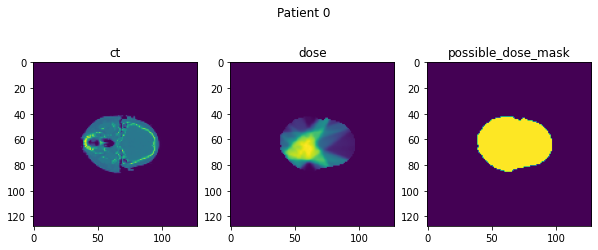

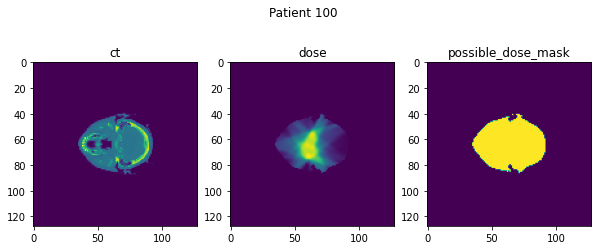

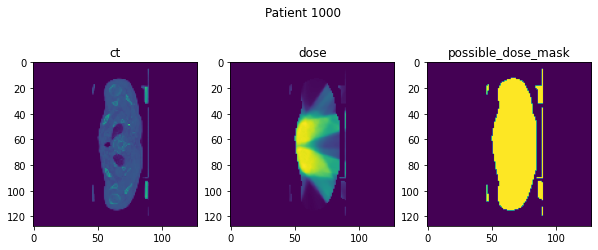

In [ ]:
# Display scanner - dose - possible_dose_mask
path_data = '/content/MVA-Dose-Prediction'
path_train = os.path.join(path_data, 'train')

samples_id = [0, 100, 1000] # samples to display
figure_name = ['ct', 'dose', 'possible_dose_mask'] # figures to display

# iterate over samples to display
for sample_id in samples_id:

  f, axes = plt.subplots(1, 3, figsize=(10, 4))
  patient_folder = os.path.join(path_train, 'sample_{sample_id}'.format(sample_id=sample_id))

  # display each figure
  for i, figure in enumerate(figure_name):
    path_file = os.path.join(patient_folder, '{figure}.npy'.format(figure=figure))
    img = np.load(path_file)
    axes[i].set_title(figure)
    axes[i].imshow(img)

  plt.suptitle('Patient {sample_id}'.format(sample_id=sample_id))
  plt.show()

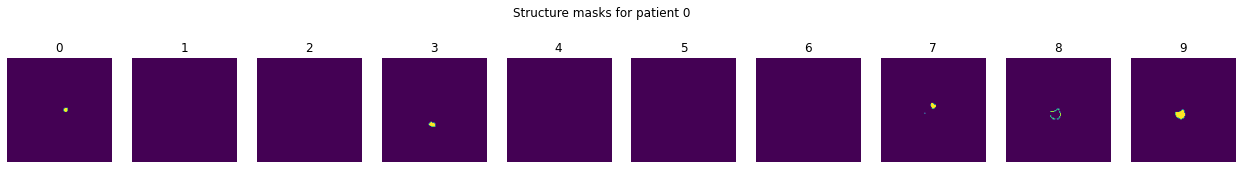

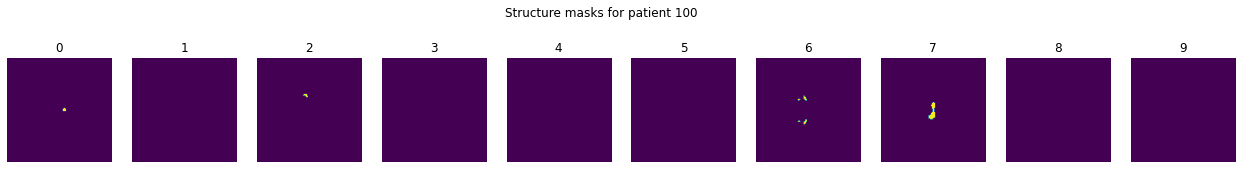

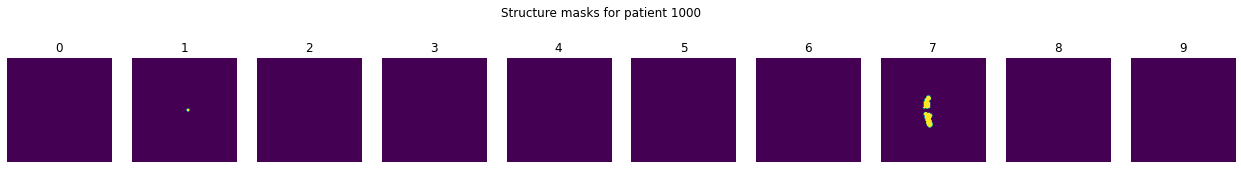

In [ ]:
# Display structure masks
path_data = '/content/MVA-Dose-Prediction'
path_train = os.path.join(path_data, 'train')

samples_id = [0, 100, 1000] # samples to display

# iterate over samples to display
for sample_id in samples_id:

  f, axes = plt.subplots(1, 10, figsize=(22, 3))
  patient_folder = os.path.join(path_train, 'sample_{sample_id}'.format(sample_id=sample_id))
  path_file = os.path.join(patient_folder, 'structure_masks.npy')
  structure_masks = np.load(path_file)

  # display each structure mask
  for i in range(10):
    img = structure_masks[i]
    axes[i].set_title('{i}'.format(i=i))
    axes[i].axis('off')
    axes[i].imshow(img)

  plt.suptitle('Structure masks for patient {sample_id}'.format(sample_id=sample_id))
  plt.show()

# Pre-processing

Patients without possible dose mask will be removed from the train and test set. It is assumed that these data do not provide any useful information for training or evaluating the model.

In [ ]:
# remove patient with null dose prediction
# load dataset
path_data = '/content/MVA-Dose-Prediction'
path_train = os.path.join(path_data, 'train')
path_val = os.path.join(path_data, 'validation')
path_test = os.path.join(path_data, 'test')

files_patern = ['ct', 'dose', 'possible_dose_mask', 'structure_masks']

# remove train sample
count_train_remove = 0
for sample_id_name in os.listdir(path_train):
    path_sample = os.path.join(path_train, sample_id_name)
    dose = np.load(os.path.join(path_sample, files_patern[1] + '.npy'))
    dose = dose.astype(np.float32)
    if(np.sum(dose)==0):
      count_train_remove += 1
      shutil.rmtree(path_sample)

# remove val sample
count_val_remove = 0
for sample_id_name in os.listdir(path_val):
    path_sample = os.path.join(path_val, sample_id_name)
    dose = np.load(os.path.join(path_sample, files_patern[1] + '.npy'))
    dose = dose.astype(np.float32)
    if(np.sum(dose)==0):
      count_val_remove += 1
      shutil.rmtree(path_sample)

print(f'Number of elements removed from train set : {count_train_remove}')
print(f'Number of elements removed from train set : {count_val_remove}')

Number of elements removed from train set : 271
Number of elements removed from train set : 54


# Load data

From now on, it is a question of loading the data via the dataset and dataloader classes of the PyTorch library. For this, we define a class capable of reading, loading and iterating on the train and test data.

In [ ]:
# custom dataset
class CustomDataset(Dataset):
    '''
    Custom dataset
    '''

    def __init__(self, data_path, files_patern = ['ct', 'dose', 'possible_dose_mask', 'structure_masks'], transform=None, set_name='train'):
        super(CustomDataset, self).__init__()

        self.transform = transform
        self.data_path = data_path # path of train, test or val folder
        self.sample_list = os.listdir(data_path) # list of samples
        self.files_patern = files_patern # files patern name
        self.set_name = set_name # train, val or test

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        '''
        Get data for patient given idx
        '''
        # get path of sample to load
        sample_path = os.path.join(self.data_path, self.sample_list[idx])

        # load files for the given patient
        ct = np.load(os.path.join(sample_path, self.files_patern[0] + '.npy'))
        possible_dose_mask = np.load(os.path.join(sample_path, self.files_patern[2] + '.npy'))
        structure_masks = np.load(os.path.join(sample_path, self.files_patern[3] + '.npy'))
        # load dose only for train and val set
        if(self.set_name == 'train' or self.set_name=='val'):
          dose = np.load(os.path.join(sample_path, self.files_patern[1] + '.npy'))
          dose = dose.astype(np.float32)
        else:
          dose = self.sample_list[idx] # return sample_id for test predictions

        # concatenate all data
        data = np.concatenate([ct[np.newaxis, :, :], possible_dose_mask[np.newaxis, :, :], structure_masks], axis=0)
        data = data.astype(np.float32)

        return data, dose

In [ ]:
# load dataset, dataloader

# load dataset
path_data = '/content/MVA-Dose-Prediction'
path_train = os.path.join(path_data, 'train')
path_val = os.path.join(path_data, 'validation')
path_test = os.path.join(path_data, 'test')

dataset_train = CustomDataset(path_train, set_name='train')
dataset_val = CustomDataset(path_val, set_name='val')
dataset_test = CustomDataset(path_test, set_name='test')

print(f'Train set successfully loaded with {len(dataset_train)} elements!')
print(f'Validation set successfully loaded with {len(dataset_val)} elements!')
print(f'Test set successfully loaded with {len(dataset_test)} elements!')

# load dataloader
torch.manual_seed(42) # fix seed to have same laoder when shuffle
batch_size = 64
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print(f'\nTrain, Validation and Test loaders successfully loaded with batch size = {batch_size}')

Train set successfully loaded with 7800 elements!
Validation set successfully loaded with 1200 elements!
Test set successfully loaded with 1200 elements!

Train, Validation and Test loaders successfully loaded with batch size = 64


# Data Augmentation

If required, a data augmentation step can be used to increase the size of the training dataset by adding modified samples via transformations from the initial train set. The following transformations are used : flip, rotation around y axis and translation. These classical transformations are taken from other projects and computer vision work for the medical field.

In [ ]:
# flip_img
def flip_img(data):
  '''
  perform flip of 3D image img
  '''
  # for each slice of the image
  for idx in range(len(data)):
    # flip it
    data[idx] = data[idx][:, ::-1]

  return data

In [ ]:
# rotation_img
def rotation_img(data):
  '''
    Perform a rotation over z of a random angle
  '''
  # angles, boder value
  list_angles=(0, 40, 80, 120, 160, 200, 240, 280, 320) # possible angle of rotation
  _angle = random.sample(list_angles, 1)[0] # select one angle
  list_boder_value=(0, 0, 0)

  # images shape, angle rotation and scaling transformation
  rows, cols = data[0].shape
  _scale = 1.

  # perform transformation
  M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), _angle, scale=_scale)
  # one each slice of the inputs
  for idx in range(len(data)):
    data[idx] = \
      cv2.warpAffine(data[idx], M, (cols, rows), borderMode=cv2.BORDER_CONSTANT, borderValue=list_boder_value)
    
  return data

In [ ]:
# random_translate
def translate_img(data):
  '''
  perform random translation over image img with the mask roi_mask of possible dose
  '''
  roi_mask = data[1] # 1 is index of possible_dose_mask
  # if no possible dose mask, no augmentation possible
  if(np.sum(roi_mask) == 0):
    return data
  # if a possible dose mask is present, perform translation
  else:
    # parameters translation
    max_shift=20
    exist_mask = np.where(roi_mask > 0)
    ori_z = data[0].shape[1:][0]
    bz = min(max_shift - 1, np.min(exist_mask[0]))
    ez = max(ori_z - 1 - max_shift, np.max(exist_mask[0]))

    data_crop = []
    # crop area of interest
    for idx in range(len(data)):
      data_crop.append(data[idx][:, bz:ez + 1])
    data = np.array(data_crop)

    # padding to perform translation
    _, ori_z  = data[0].shape[:]
    new_z = 128
    pad_z = new_z - ori_z
    pad_z_1 = random.randint(0, pad_z)
    pad_z_2 = pad_z - pad_z_1

    # apply padding to get the shape of the initial image
    new_data = []
    for idx in range(len(data)):
      new_data.append(np.pad(data[idx], ((0, 0), (pad_z_1, pad_z_2)),
                                mode='constant',
                                constant_values=[0, 0]))
    data = np.array(new_data)
  
  return data

Once the 3 transformations are applied, we define **transform_data** which allows us to apply the 3 successive transformations to input data.

In [ ]:
# transorm_data
def transform_data(data):
  '''
  perform flip, rotate and translation over data
  '''
  p_flip, p_rotate, p_translate = 0.8, 0.4, 0.8

  # flip
  if(random.random() < p_flip):
    data = flip_img(data)

  # rotate
  if(random.random() < p_rotate):
    data = rotation_img(data)

  # translation
  if(random.random() < p_translate):
    data = translate_img(data)

  return data

Finally, we define **perform_data_aug** which applies the data augmentation to the input data. As a parameter, the **percentage_aug** argument is used to select the percentage of trainset data that will be augmented.

In [ ]:
# perform_data_aug
def perform_data_aug(pourcentage_aug=10):
  '''
  perform data augmentation over pourcentage_aug% of the train set
  directly modifies train files, return None
  '''

  # path to the train set
  path_train = '/content/MVA-Dose-Prediction/train'

  # start by removing augmented sample in case of multiple call of perform_data_aug
  for sample_id in os.listdir(path_train):
    if('aug' in sample_id):
      path_sample_aug = os.path.join(path_train, sample_id)
      shutil.rmtree(path_sample_aug)

  start_nb_samples = len(os.listdir(path_train))
  print(f'Starting Data Augmentation !')

  # names of files
  files_patern = ['ct', 'dose', 'possible_dose_mask', 'structure_masks']

  max_aug = (pourcentage_aug/100)*len(os.listdir(path_train)) # max number of augmentation
  nb_aug = 0 # number of sample augmented

  # iterate over sample
  start_time = time.time()
  for sample_id in os.listdir(path_train):
    
    # path sample
    path_sample = os.path.join(path_train, sample_id)
    
    # load files for the given patient
    ct = np.load(os.path.join(path_sample, files_patern[0] + '.npy'))
    possible_dose_mask = np.load(os.path.join(path_sample, files_patern[2] + '.npy'))
    structure_masks = np.load(os.path.join(path_sample, files_patern[3] + '.npy'))
    dose = np.load(os.path.join(path_sample, files_patern[1] + '.npy'))
    dose = dose.astype(np.float32)

    # concatenate data
    data = np.concatenate([ct[np.newaxis, :, :], possible_dose_mask[np.newaxis, :, :], 
                          dose[np.newaxis, :, :], structure_masks], axis=0)
    data = data.astype(np.float32)

    # perform data augmentation
    if(nb_aug < max_aug):
      nb_aug += 1
      # new id for augmented sample
      sample_id_aug = sample_id + 'aug'
      # perform data augmentation
      data_aug = transform_data(data)
      ct = data_aug[0]
      possible_dose_mask = data_aug[1]
      dose = data_aug[2]
      structure_masks = data_aug[3:]
      # save files
      path_sample_aug = os.path.join(path_train, sample_id_aug)
      # if repository exists, remove it
      if os.path.exists(path_sample_aug):
        shutil.rmtree(path_sample_aug)
      os.mkdir(path_sample_aug)

      np.save(os.path.join(path_sample_aug, 'ct.npy'), ct)
      np.save(os.path.join(path_sample_aug, 'dose.npy'), dose)
      np.save(os.path.join(path_sample_aug, 'possible_dose_mask.npy'), possible_dose_mask)
      np.save(os.path.join(path_sample_aug, 'structure_masks.npy'), structure_masks)

  end_time = time.time() - start_time
  end_nb_samples = len(os.listdir(path_train))
  print(f'Data Augmentation successfully done !')
  print(f'> Initial number of samples : {start_nb_samples}')
  print(f'> Final number of samples : {end_nb_samples}')
  print(f'> + {end_nb_samples - start_nb_samples} augmented samples !')
  print(f'> Execution times : {end_time:.2f}s !')

  return

In [ ]:
# finally, perform data augmentation
perform_data_aug(100)

Starting Data Augmentation !
Data Augmentation successfully done !
> Initial number of samples : 7529
> Final number of samples : 15058
> + 7529 augmented samples !
> Execution times : 115.54s !


Once the data has been augmented, it is now time to reload the data coders with augmented images!

In [ ]:
# reload data with augmented
## load dataset, dataloader

# load dataset
path_data = '/content/MVA-Dose-Prediction'
path_train = os.path.join(path_data, 'train')
path_val = os.path.join(path_data, 'validation')
path_test = os.path.join(path_data, 'test')

dataset_train = CustomDataset(path_train, set_name='train')
dataset_val = CustomDataset(path_val, set_name='val')
dataset_test = CustomDataset(path_test, set_name='test')

print(f'Train set successfully loaded with {len(dataset_train)} elements!')
print(f'Validation set successfully loaded with {len(dataset_val)} elements!')
print(f'Test set successfully loaded with {len(dataset_test)} elements!')

# load dataloader
torch.manual_seed(42) # fix seed to have same laoder when shuffle
batch_size = 64
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

print(f'\nTrain, Validation and Test loaders successfully loaded with batch size = {batch_size}')

Train set successfully loaded with 15058 elements!
Validation set successfully loaded with 1146 elements!
Test set successfully loaded with 1200 elements!

Train, Validation and Test loaders successfully loaded with batch size = 64


# Training

Now it is a matter of training the model.

In [ ]:
# Libraries
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR, MultiStepLR

Below are implemented **train_step** and **get_lr** which allow to train the model for a given epoch et to return the learning rate of the model at a given time.

In [ ]:
# functions utils to train
def train_step(loader, model, criterion, optimizer, epoch):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  epoch_loss_sum = []
  predictions, labels = [], []

  for i, (data, label) in enumerate(loader, 1):

    data, label = data.to(device), label.to(device)

    prediction = model(data)
    prediction = prediction.view(label.shape)
    #loss = criterion(prediction, label, data[:, 1, :, :])
    loss = criterion(prediction, label)
    
    if model.training:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    epoch_loss_sum += [loss.item()]
    predictions += [0]# [prediction]
    labels += [0]#[label]

    if((i+1)%25==0):
      print('Step {i}/{n} - mean loss : {epoch_loss_current}'.format(i=i+1, n=len(loader), epoch_loss_current=np.mean(epoch_loss_sum)))

  return np.mean(epoch_loss_sum), prediction, labels

# get_lr function
def get_lr(optimizer):
    '''
    returns learning rate for the optimizer
    '''
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Model

Then, it is time to implement the ResNet model. As ResNet is widely used in computer vision, we used a version of the model available on github and we change some parameters according to our needs, i.e. input/output dimensions, number of layers, etc...

In [ ]:
# Model ResNet
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

__all__ = [
    'ResNet', 'resnet10', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'resnet200'
]


# define convolution
def conv2x2(in_planes, out_planes, stride=1, dilation=1):
    '''
    from parameters, returns nn convolution
    '''
    # convolution with padding
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, dilation=dilation, stride=stride, padding=dilation, bias=False)

# define downsampling_block block of ResNet architecture 
def downsampling_block(x, planes, stride, no_cuda=False):
    '''
    from a given input x ; planes and stride
    returns output of downsampling block with 0 padding
    '''
    # average pooling
    out = F.avg_pool2d(x, kernel_size=1, stride=stride)
    # zero padding
    zero_pads = torch.Tensor(out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4)).zero_()
    if not no_cuda:
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()
    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out

# define basic block of ResNet architecture 
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        '''
        initialization of layers of the block : conv, batch_norm, ReLU, conv, batch_norm and ReLU with residual
        '''
        super(BasicBlock, self).__init__()
        self.conv1 = conv2x2(inplanes, planes, stride=stride, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv2x2(planes, planes, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        '''
        from input x
        returns output of forward propagation of the basic block
        '''
        residual = x
        # 2d convolution followed by batch norm and relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # 2d convolution followed by batch norm
        out = self.conv2(out)
        out = self.bn2(out)

        # down sample if downsampling block with pooling
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual # residual connection
        out = self.relu(out) # relu activation

        return out

# implement Bottleneck class
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        '''
        initialization of layers of the bottleneck
        '''
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, dilation=dilation, padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        '''
        from input x
        returns output of forward propagation of the bottleneck
        '''
        residual = x

        # 2d convolution followed by batch norm and relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 2d convolution followed by batch norm and relu
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # 2d convolution followed by batch norm
        out = self.conv3(out)
        out = self.bn3(out)

        # down sample if downsampling block with pooling
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual # residual connection
        out = self.relu(out) # relu activation

        return out

# ResNet class
class ResNet(nn.Module):

    def __init__(self, block, layers, sample_input_D, sample_input_H, sample_input_W, output_dim, shortcut_type='B', no_cuda = False):
        '''
        initialize the model with wanted architecture
        '''
        self.inplanes = 64
        self.no_cuda = no_cuda
        super(ResNet, self).__init__()
        # layer for the input
        self.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # initialize model layers
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], shortcut_type, stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], shortcut_type, stride=1, dilation=4)

        # initialize sequence of transpose convolutions
        # to compute the output : dose prediction
        self.conv_output = nn.Sequential(
                                        nn.ConvTranspose2d(512 * block.expansion, 512, 2, stride=2),
                                        nn.BatchNorm2d(512),
                                        nn.ReLU(inplace=True),
                                        nn.ConvTranspose2d(512, 256, 2, stride=2),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(inplace=True),
                                        nn.ConvTranspose2d(256, 128, 2, stride=2),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False), 
                                        nn.BatchNorm2d(32),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(32, output_dim, kernel_size=1, stride=1, bias=False) 
                                        )
        # kaiming initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight = nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    # function to initialize and returns sequence of layer
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(downsampling_block, planes=planes * block.expansion, stride=stride, no_cuda=self.no_cuda)
            else:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False), nn.BatchNorm2d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride=stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion

        # layers is a list containing block of ResNet
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        from given input x
        returns output of the forward propagation of the ResNet model
        '''
        # layer to deal with input
        print(f'input: {x.shape}')
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        print(f'input: {x.shape}')
        # sequences of layers of the ResNet
        x = self.layer1(x)
        print(f'layer1: {x.shape}')
        x = self.layer2(x)
        print(f'layer2: {x.shape}')
        x = self.layer3(x)
        print(f'layer3: {x.shape}')
        x = self.layer4(x)
        print(f'layer4: {x.shape}')
        # output layer
        x = self.conv_output(x)
        print(f'output: {x.shape}')

        return x

# implementation of resnet18, resnet34 and resnet50
def resnet18(**kwargs):
    """Constructs a ResNet-18 model.
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model


def resnet34(**kwargs):
    """Constructs a ResNet-34 model.
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

Once the model is implemented, it is time to initialize it with optimizer, scheduler, loss function and some parameters.

In [ ]:
# initialize model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet34(sample_input_D=128, sample_input_H=128, sample_input_W=128,
                    output_dim=1, shortcut_type='B')
model = model.to(device)

epochs = 30
criterion = nn.L1Loss() # loss
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=3, gamma=0.1) # scheduler
scheduler = MultiStepLR(optimizer, milestones=[10, 20, 25], gamma=0.1) # scheduler

Then, we can start training.

In [ ]:
# training iteration
start = time.time()

losses_train, losses_val = [], [] # stock losses train, validation

for epoch in range(epochs): 
  print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs))
  print(f'Learning rate : {get_lr(optimizer)}')

  model.train() # training
  epoch_loss, _, _ = train_step(loader_train, model, criterion, optimizer, epoch)
  losses_train += [epoch_loss]
  print('> Training Loss : {epoch_loss}!'.format(epoch_loss=epoch_loss))

  with torch.no_grad(): # validation
    model.eval() 
    epoch_loss, _, _ = train_step(loader_val, model, criterion, optimizer, epoch)
    epoch_loss = 0
    losses_val += [epoch_loss]
    print('> Validation Loss : {epoch_loss}!\n'.format(epoch_loss=epoch_loss))

  scheduler.step() # scheduler step

end = time.time()
exec_time = end - start
print(f'\n> Execution time : {exec_time:.2f}s')

# Compute loss on validation set

Once the model is trained, the model is tested on the validation sample to calculate the mean and standard deviation of the losses, to see how well the model can generalise.

In [ ]:
# load test loader witch batch size = 1
loader_val_loss = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

In [ ]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
losses_val = [] # lists to stock prediction, samples_id

for i, (data, label) in enumerate(loader_val_loss):
  # get input and sample
  data, label = data.to(device), label.to(device)

  # make prediction
  prediction = model(data)
  
  # get prediction and mask as numpy
  prediction = prediction[0][0].detach().cpu().numpy()
  possible_dose_mask = data[0][1].detach().cpu().numpy()
  # constraint mask to prediction
  new_prediction = prediction.copy()
  new_prediction[possible_dose_mask==0] = 0

  # compute loss
  label_np = label[0].detach().cpu().numpy()
  loss = criterion(torch.tensor(new_prediction), torch.tensor(label_np))
  losses_val.append(loss.item())

In [ ]:
# print mean and standart deviation of validation losses
mean_loss, std_loss = np.mean(losses_val), np.std(losses_val)
print(f'Mean Loss : {mean_loss}')
print(f'Std Loss : {std_loss}')

Mean Loss : 0.45287515222175273
Std Loss : 0.3112716751372514


# Prediction on test set

Finally, prediction are made on the test set to get the score for the challenge.

In [ ]:
# load test loader witch batch size = 1
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

In [ ]:
# remove results repository
!rm -rf results

In [ ]:
# Predictions on test set

# directory where results are saved
path_results = 'results/'
# create empty directory
if not os.path.exists(path_results):
  os.makedirs(path_results)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictions, samples_id = [], [] # lists to stock prediction, samples_id

for i, (data, sample_id) in enumerate(loader_test, 1):

  # get input and sample
  data, sample_id = data.to(device), list(sample_id)

  # make prediction
  prediction = model(data)
  
  # get prediction and mask as numpy
  prediction = prediction[0][0].detach().cpu().numpy()
  possible_dose_mask = data[0][1].detach().cpu().numpy()
  # constraint mask to prediction
  new_prediction = prediction.copy()
  new_prediction[possible_dose_mask==0] = 0

  # save predictions and samples
  predictions.append(new_prediction)
  samples_id += [sample_id[0]]

# list to array
predictions_array = np.array(predictions)

# save prediction as .npy file in 'results'
for pred, sample_id in zip(predictions_array, samples_id):
  path_to_save = os.path.join(path_results, sample_id + '.npy')
  np.save(path_to_save, pred)
  print(f'Sample {sample_id} prediction saved to {path_to_save} !')

# Folder as a zip and download it
shutil.make_archive('submission', 'zip', 'results/')

Sample sample_9533 prediction saved to results/sample_9533.npy !
Sample sample_9218 prediction saved to results/sample_9218.npy !
Sample sample_9857 prediction saved to results/sample_9857.npy !
Sample sample_9923 prediction saved to results/sample_9923.npy !
Sample sample_9127 prediction saved to results/sample_9127.npy !
Sample sample_9807 prediction saved to results/sample_9807.npy !
Sample sample_9560 prediction saved to results/sample_9560.npy !
Sample sample_9678 prediction saved to results/sample_9678.npy !
Sample sample_9257 prediction saved to results/sample_9257.npy !
Sample sample_10083 prediction saved to results/sample_10083.npy !
Sample sample_9139 prediction saved to results/sample_9139.npy !
Sample sample_10024 prediction saved to results/sample_10024.npy !
Sample sample_9679 prediction saved to results/sample_9679.npy !
Sample sample_10191 prediction saved to results/sample_10191.npy !
Sample sample_9321 prediction saved to results/sample_9321.npy !
Sample sample_9828 

'/content/submission.zip'

# Qualitative results

In [ ]:
labels = []
predictions = []
model.eval()
for i, (data, label) in enumerate(loader_val_loss):
  # get input and sample
  data, label = data.to(device), label.to(device)

  # make prediction
  prediction = model(data)
  
  # get prediction and mask as numpy
  prediction = prediction[0][0].detach().cpu().numpy()
  possible_dose_mask = data[0][1].detach().cpu().numpy()
  # constraint mask to prediction
  new_prediction = prediction.copy()
  new_prediction[possible_dose_mask==0] = 0
  
  labels.append(label.detach().cpu().numpy()[0])
  predictions.append(new_prediction)

Loss : 0.4197404086589813


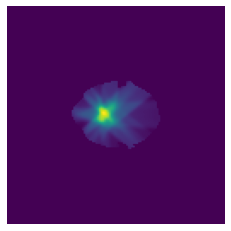

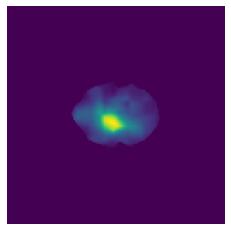

In [ ]:
# select idx of validation sample to display
idx = 25
img_label = labels[idx]
img_prediction = predictions[idx]

print(f'Loss : {criterion(torch.tensor(img_prediction), torch.tensor(img_label)).item()}')

# label
plt.imshow(img_label)
plt.axis('off')
plt.savefig(f'label_{idx}.png', bbox_inches='tight')
plt.show()

# prediction
plt.imshow(img_prediction)
plt.axis('off')
plt.savefig(f'predictions_{idx}.png', bbox_inches='tight')
plt.show()

# END of the notebook !

Thank you for reading !